## About dataset

#### https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
Dataset contains 7022 images of human brain MRI images which are classified into 4 classes: 
1. glioma 
2. meningioma
3. pituitary
4. no tumor


### 1. Data analysis

In [ ]:
import os, os.path
import matplotlib.pyplot as plt

Let's count how many images are in train/test directories

In [140]:
train_dir = "Training"
test_dir = "Testing"

In [141]:
def countClasses(directory):
    counts = {}
    for path in os.listdir(directory):
        dirPath = os.path.join(directory, path)
        if os.path.isdir(dirPath):
            counts[path] = len([name for name in os.listdir(dirPath) 
                                if os.path.isfile(os.path.join(dirPath, name))])
        
    return counts

In [142]:
train_counts = countClasses(train_dir)
print(train_counts)

{'pituitary': 1457, 'notumor': 1595, 'glioma': 1321, 'meningioma': 1339}


<BarContainer object of 4 artists>

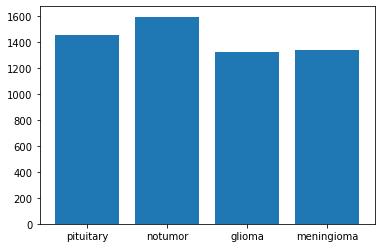

In [143]:
plt.bar(train_counts.keys(), train_counts.values())

In [144]:
test_counts = countClasses(test_dir)
print(test_counts)

{'pituitary': 300, 'notumor': 405, 'glioma': 300, 'meningioma': 306}


<BarContainer object of 4 artists>

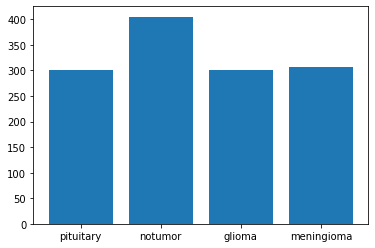

In [145]:
plt.bar(test_counts.keys(), test_counts.values())

### 2. Data preprocessing 

In [111]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras

batch_size = 32
img_height = 180
img_width = 180

Let's use 10% of training data as validation set.
Each image is going to be resized to 180x180 pixels

In [146]:
train_ds = image_dataset_from_directory(
  "Training/",
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 5141 files for training.


In [147]:
val_ds = image_dataset_from_directory(
  "Training/",
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 571 files for validation.


As expected in single batch there are 32 images of 180x180 size

In [149]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [158]:
import tensorflow as tf
from tensorflow import keras
import keras.layers

The RGB values are in range of [0,255]. Let's rescale that to [0,1] range

In [183]:
preprocessing = [
    Rescaling(1./255),
]

### 3. Creating and training models

First, let's create simple network using Flatten layer

In [189]:
import numpy as np
from keras import Sequential
from keras import optimizers

num_classes = 4

modelFlatten = Sequential

modelFlatten = Sequential()
modelFlatten.add(Rescaling(1./255))
modelFlatten.add(Flatten(input_shape=(img_height, img_width, 3)))
modelFlatten.add(Dense(num_classes))
modelFlatten.add(Activation("softmax"))

modelFlatten.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [177]:
from keras.callbacks import History

history = modelFlatten.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    shuffle=True
)

Epoch 1/10
161/161 [==============================] - 2s 13ms/step - loss: 0.3932 - accuracy: 0.8969 - val_loss: 2.8809 - val_accuracy: 0.6287
Epoch 2/10
161/161 [==============================] - 2s 13ms/step - loss: 0.5314 - accuracy: 0.8767 - val_loss: 1.2483 - val_accuracy: 0.8284
Epoch 3/10
161/161 [==============================] - 2s 13ms/step - loss: 0.3080 - accuracy: 0.9179 - val_loss: 1.4977 - val_accuracy: 0.8301
Epoch 4/10
161/161 [==============================] - 2s 13ms/step - loss: 0.5937 - accuracy: 0.9053 - val_loss: 4.6173 - val_accuracy: 0.5517
Epoch 5/10
161/161 [==============================] - 2s 13ms/step - loss: 0.3485 - accuracy: 0.9222 - val_loss: 1.2887 - val_accuracy: 0.8494
Epoch 6/10
161/161 [==============================] - 2s 12ms/step - loss: 0.2659 - accuracy: 0.9280 - val_loss: 1.7975 - val_accuracy: 0.8336
Epoch 7/10
161/161 [==============================] - 2s 13ms/step - loss: 0.2959 - accuracy: 0.9236 - val_loss: 1.5260 - val_accuracy: 0.8109

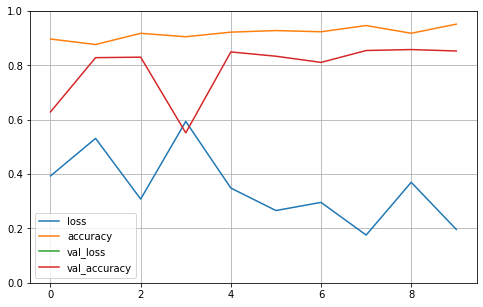

In [178]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [179]:
modelFlatten.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_36 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 flatten_20 (Flatten)        (None, 97200)             0         
                                                                 
 dense_20 (Dense)            (None, 4)                 388804    
                                                                 
 activation_20 (Activation)  (None, 4)                 0         
                                                                 
Total params: 388,804
Trainable params: 388,804
Non-trainable params: 0
_________________________________________________________________


In [180]:
TRAINED_MODEL_DIR = "trained_models/"

In [181]:
model.save(TRAINED_MODEL_DIR+"modelFlatten.h5")

Convolutional networks